In [1]:
import numpy as np
import os
os.chdir('c:\\Users\\luism\\Documents\\projects\\bayesian_learning_for_partially_observable_systemss\\iPMCMC\\ipmcmc')
display(os.getcwd())
%run seq_mc

'c:\\Users\\luism\\Documents\\projects\\bayesian_learning_for_partially_observable_systemss\\iPMCMC\\ipmcmc'

# Context

Explain here HMM etc ...

# Sequential Montecarlo

## Linear Gaussian State Space Model

In [2]:
%run generate_data.py
%run linear_gaussian_state_model

# 4.1. Linear Gaussian State Space Model
from scipy.spatial.transform import Rotation as R
np.random.seed(420)

# Parameters
r = R.from_rotvec(np.array([7*np.pi/10, 3*np.pi/10, np.pi/20]))
rotation_matrix = r.as_dcm()
scaling_matrix = 0.99*np.eye(3)
beta = np.random.dirichlet(np.ones(20)*0.2, 3).transpose()
alpha = scaling_matrix@rotation_matrix
t_max = 50
mu = np.array([0, 1, 1])
start_var = 0.1*np.eye(3)
omega = np.eye(3)
sigma = 0.1*np.eye(20)


n_particles = 50

l_f_t = [L_F_t(default_mean=np.zeros(3),default_cov=omega,default_alpha=alpha) for t in range(0, t_max)]
l_q_t = [L_Mu(default_mean=mu, default_cov=start_var)]+[L_Q_t(default_mean=np.zeros(3),default_cov=omega,default_alpha=alpha) for t in range(1, t_max)]
l_g_t = [L_G_t(default_mean=np.zeros(20),default_cov=sigma,default_beta=beta) for t in range(0, t_max)]


# If we want to change the parameters
assert np.all(np.linalg.eigvals(start_var) > 0)
assert np.all(np.linalg.eigvals(omega) > 0)
assert np.all(np.linalg.eigvals(sigma) > 0)

l_states, l_observations = linear_gaussian_state_space(t_max=t_max, mu=mu, start_var=start_var, transition_var=omega, noise_var=sigma, transition_coeffs=alpha, observation_coeffs=beta)
display((l_states.shape, l_observations.shape))

l_particles, l_weights, l_ancestors = seq_mc(observations=l_observations, n_particles=n_particles,
       f_t=l_f_t, q_t=l_q_t, g_t=l_g_t)

((50, 3), (50, 20))

100%|██████████| 49/49 [00:08<00:00,  5.81it/s]


 ## Nonlinear State Space Model

In [3]:
%run non_linear_gaussian_state_model
%run seq_mc
# 4.2. Nonlinear State Space Model
np.random.seed(420)
t_max = 50
mu = 0
start_std = np.sqrt(5)
omega = np.sqrt(10)
sigma = np.sqrt(10)

nl_states, nl_observations = nonlinear_gaussian_state_space(t_max=t_max, mu=mu, start_std=start_std, transition_std=omega, noise_std=sigma)

display((nl_states.shape, nl_observations.shape))

n_particles = 50

nl_f_t = [NL_F_t(default_mean=0,default_std=omega) for t in range(0, t_max)]
nl_q_t = [NL_Mu(default_mean=mu, default_std=start_std)]+[NL_Q_t(default_mean=0,default_std=omega) for t in range(1, t_max)]
nl_g_t = [NL_G_t(default_mean=0,default_std=sigma) for t in range(0, t_max)]
print(len(nl_f_t), len(nl_q_t), len(nl_g_t))

nl_particles, nl_weights, nl_ancestors = seq_mc(observations=nl_observations, n_particles=n_particles,
       f_t=nl_f_t, q_t=nl_q_t, g_t=nl_g_t)

((50,), (50,))

100%|██████████| 49/49 [00:04<00:00, 11.57it/s]


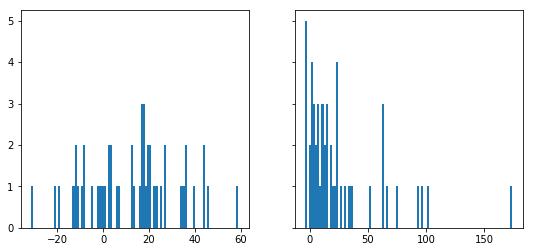

In [4]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9, 4), sharey=True)
ax1.hist(nl_states, bins=100)
ax2.hist(nl_observations, bins=100)
plt.show()

In [5]:
nl_states.shape, nl_observations.shape

((50,), (50,))

RESULT ANALYSIS

In [6]:
   nl_ancestors.shape

(50, 49)

In [7]:
import networkx as nx



In [17]:
G = nx.Graph()
for p_i in range(nl_ancestors.shape[0]):
    G.add_node("p={};t={}".format(p_i, 0))
for t_i in range(nl_ancestors.shape[1]):
    for p_i, a_t_i in enumerate(nl_ancestors[:,t_i]):
        G.add_node("p={};t={}".format(int(p_i), int(t_i+1)))
        G.add_edge("p={};t={}".format(int(a_t_i), int(t_i)) ,"p={};t={}".format(int(p_i), int(t_i+1)))
import matplotlib.pyplot as plt
plt.figure(figsize=(120,120))
coeff = 10000
fixed_positions = {node: (int(node.split(';')[0][2:])*coeff,int(node.split(';')[1][2:])*coeff)
    for node in G.nodes
}
pos = nx.spring_layout(G,pos=fixed_positions, fixed=G.nodes)
nx.draw_networkx(G,pos)
plt.savefig('NL_graph.png')
plt.close()

In [16]:
G = nx.Graph()
for p_i in range(l_ancestors.shape[0]):
    G.add_node("p={};t={}".format(p_i, 0))
for t_i in range(l_ancestors.shape[1]):
    for p_i, a_t_i in enumerate(l_ancestors[:,t_i]):
        G.add_node("p={};t={}".format(int(p_i), int(t_i+1)))
        G.add_edge("p={};t={}".format(int(a_t_i), int(t_i)) ,"p={};t={}".format(int(p_i), int(t_i+1)))
import matplotlib.pyplot as plt
plt.figure(figsize=(120,120))
coeff = 10000
fixed_positions = {node: (int(node.split(';')[0][2:])*coeff,int(node.split(';')[1][2:])*coeff)
    for node in G.nodes
}
pos = nx.spring_layout(G,pos=fixed_positions, fixed=G.nodes)
nx.draw_networkx(G,pos)
plt.savefig('L_graph.png')
plt.close()